In [ ]:
#Aty Sokoy, Lab 5
#For this Lab I use Online Retail data. This is a business data for Online Retail from the UCI Machine Learning Repository
#This is a transactional data set which containing all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.
#Key features: InvoiceNo, StockCode, Description, Quantity, InvoiceData, UnitPrice, CustomerID, and Country

In [9]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #just incase use.
from datetime import datetime


In [5]:
#Get the dataset and show the important data
file = pd.read_csv("OnlineRetail.csv")

#Remove any order that being cancel
file = file[~file['InvoiceNo'].astype(str).str.startswith('C')]
 
# printing the top 10 rows
display(file.head(10))

#Row that doesn't have customer ID
file = file.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
file['InvoiceDate'] = pd.to_datetime(file['InvoiceDate'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [6]:
# Get the latest date in the dataset (+1 day to avoid recency=0)
snapshot_date = file['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID and compute features
customer_features = file.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency (days since last purchase)
    'InvoiceNo': 'nunique',                                   # Frequency (number of transactions)
    'Quantity': ['sum', 'mean'],                              # Total Quantity & Avg. Quantity per transaction
    'UnitPrice': lambda x: (x * file.loc[x.index, 'Quantity']).sum(),  # Monetary (total spending)
    'StockCode': 'nunique',                                   # Unique products purchased
    'Country': 'nunique'                                      # Country diversity (optional)
})

# Rename columns for clarity
customer_features.columns = [
    'Recency', 
    'Frequency', 
    'TotalQuantity', 
    'AvgQuantity', 
    'Monetary', 
    'UniqueProducts', 
    'CountryDiversity'
]

# Reset index to make CustomerID a column
customer_features = customer_features.reset_index()

In [15]:
#from sklearn.preprocessing import StandardScaler

# Select only numeric columns (excluding CustomerID)
#X = customer_features.drop('CustomerID', axis=1)

# Standardize the features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)  # for PCA

In [16]:
#Standadize the feature 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(customer_features)
cov_matrix = np.cov(rfm_scaled, rowvar=False)

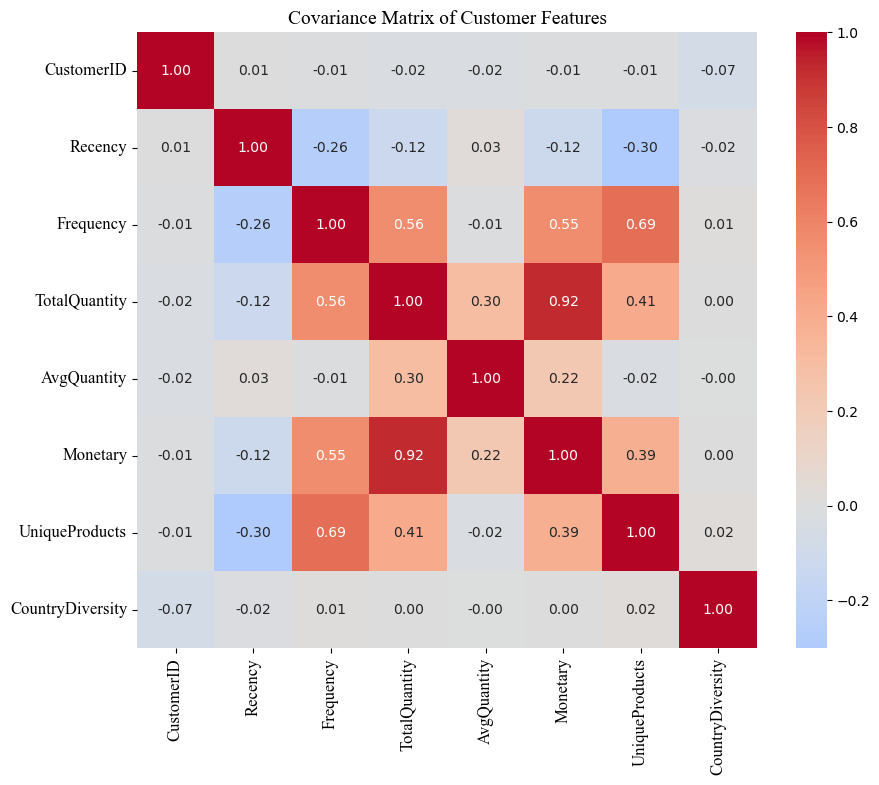

In [19]:
#Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, 
            annot=True, 
            fmt=".2f",
            cmap="coolwarm",
            center=0,
            xticklabels=customer_features.columns,
            yticklabels=customer_features.columns)
plt.title("Covariance Matrix of Customer Features", fontname="Times New Roman", size=14)
plt.xticks(fontname="Times New Roman", size=12)
plt.yticks(fontname="Times New Roman", size=12)
#plt.savefig("Lab5_Aty_CovarianceHeatmap.png")
plt.show()

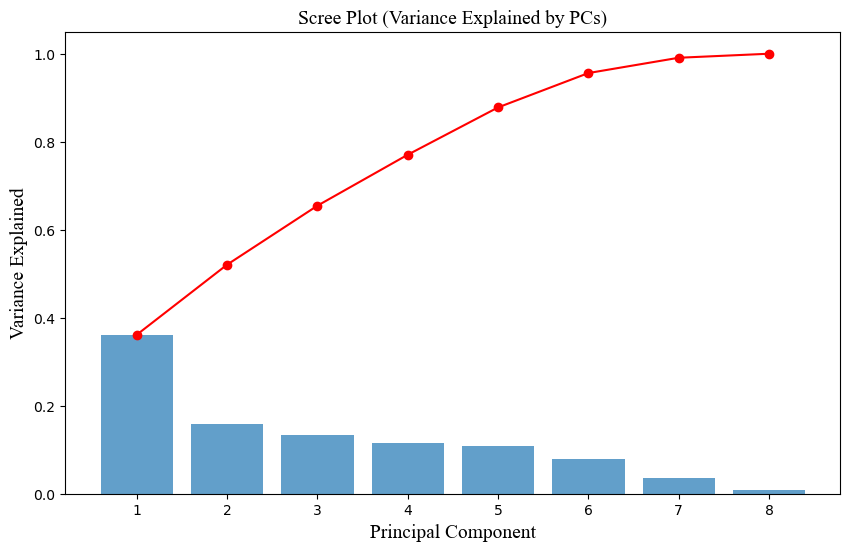

In [20]:
#Compute PCA
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(rfm_scaled)

#Scree Plot (Eigenvalue)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel("Principal Component", fontname="Times New Roman", size=14)
plt.ylabel("Variance Explained", fontname="Times New Roman", size=14)
plt.title("Scree Plot (Variance Explained by PCs)", fontname="Times New Roman", size=14)
#plt.savefig("Lab5_Aty_ScreePlot.png")
plt.show()

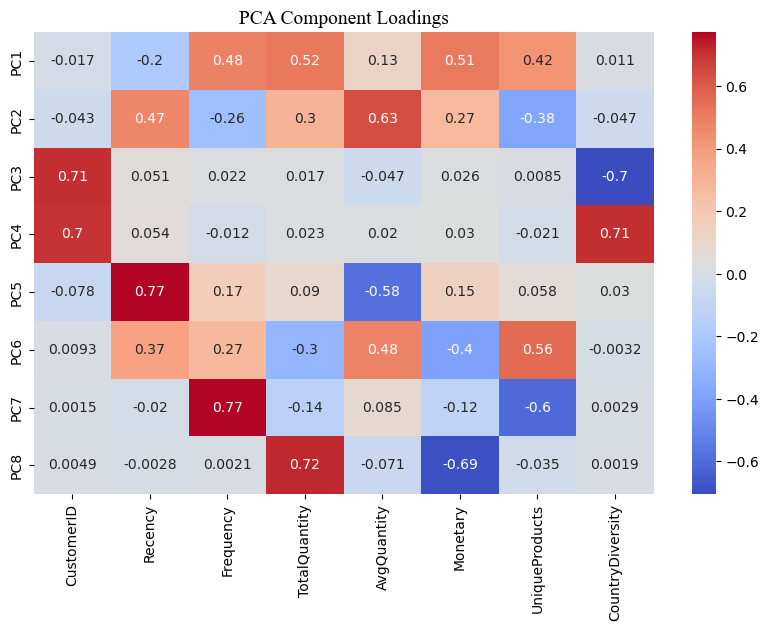

In [22]:
#Loading Heatmap (EigenVectore)
plt.figure(figsize=(10, 6))
sns.heatmap(pca.components_,
            cmap="coolwarm",
            annot=True,
            yticklabels=[f"PC{i+1}" for i in range(pca.n_components_)],
            xticklabels=customer_features.columns)
plt.title("PCA Component Loadings", fontname="Times New Roman", size=14)
#plt.savefig("Aty_LoadingsHeatmap.png")
plt.show()

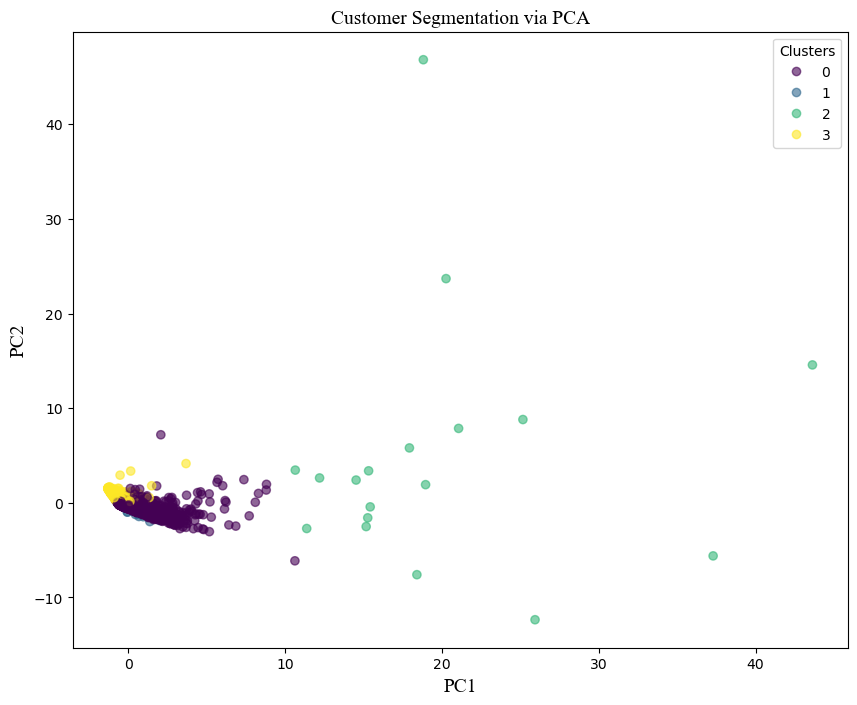

In [23]:
#2D PCA Scatterplot (Colored by Clusters)
from sklearn.cluster import KMeans

# Project data onto first 2 PCs
pca_results = pca.transform(rfm_scaled)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(pca_results)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_results[:, 0], pca_results[:, 1], c=clusters, cmap="viridis", alpha=0.6)
plt.title("Customer Segmentation via PCA", fontname="Times New Roman", size=14)
plt.xlabel("PC1", fontname="Times New Roman", size=14)
plt.ylabel("PC2", fontname="Times New Roman", size=14)
plt.legend(*scatter.legend_elements(), title="Clusters")
#plt.savefig("Aty_PCASegmentation.png")
plt.show()

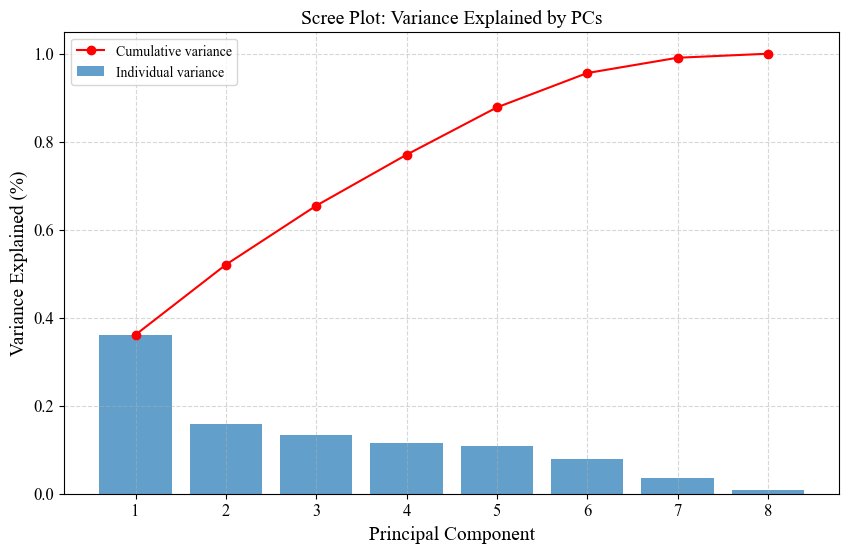

In [24]:
# After fitting PCA (assuming pca is already fitted)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), 
        pca.explained_variance_ratio_, 
        alpha=0.7, 
        label='Individual variance')
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 
         'ro-', 
         label='Cumulative variance')
plt.xlabel('Principal Component', fontname='Times New Roman', size=14)
plt.ylabel('Variance Explained (%)', fontname='Times New Roman', size=14)
plt.title('Scree Plot: Variance Explained by PCs', fontname='Times New Roman', size=14)
plt.legend(fontsize=12, prop={'family': 'Times New Roman'})
plt.xticks(fontname='Times New Roman', size=12)
plt.yticks(fontname='Times New Roman', size=12)
plt.grid(linestyle='--', alpha=0.5)
#plt.savefig('Aty_ScreePlot.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
def biplot(score, coeff, feature_names):
    plt.figure(figsize=(12, 8))
    xs = score[:, 0]  # PC1 scores
    ys = score[:, 1]  # PC2 scores
    n = min(coeff.shape[0], len(feature_names))  # Safeguard against mismatch
    
    # Scale scores for better visualization
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    scaled_xs = xs * scalex
    scaled_ys = ys * scaley
    
    # Plot data points
    plt.scatter(scaled_xs, scaled_ys, alpha=0.5, edgecolors='k', s=60)
    
    # Plot feature vectors
    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], 
                 color='r', alpha=0.8, head_width=0.03)
        plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, 
                 feature_names[i], 
                 color='darkred',
                 fontname='Times New Roman',
                 size=12,
                 weight='bold')
    
    # Formatting
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', 
               fontname='Times New Roman', size=14)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', 
               fontname='Times New Roman', size=14)
    plt.title('Biplot of Principal Components', 
              fontname='Times New Roman', size=14, pad=20)
    plt.grid(linestyle='--', alpha=0.6)
    
    # Equal aspect ratio
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.tight_layout()
    #plt.savefig('Lab5_YourName_Biplot.png', dpi=300, bbox_inches='tight')
    plt.show()